In [ ]:
pip install PyPortfolioOpt

In [ ]:
pip install yfinance

In [ ]:
pip install pulp

In [ ]:
pip install quandl

In [1]:
import pandas as pd
import numpy as np
import requests
import re
import quandl
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
df= pd.read_csv("input_data.csv")
df.Date = pd.to_datetime(df.Date, dayfirst = True)
df.set_index("Date", inplace = True)
df.head()

,DAI-USD,BUSD-USD,TUSD-USD,USDC-USD,USDT-USD
Date,,,,,
2019-11-22,0.992598,1.001011,1.002206,1.001247,1.003045
2019-11-23,1.016282,1.010858,1.011321,1.011744,1.013130
2019-11-24,1.002270,1.018518,1.017851,1.008879,1.017519
2019-11-25,1.007021,1.001980,1.003634,1.000393,1.003114
2019-11-26,1.006096,1.008688,1.009488,1.007935,1.009773


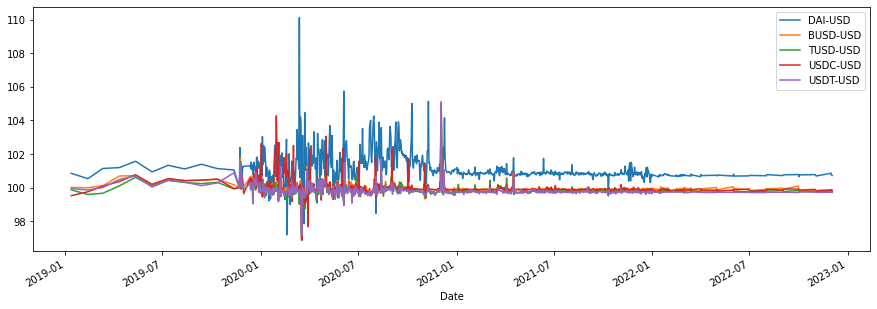

In [4]:
(df / df.iloc[0] * 100).plot(figsize = (15,5));
plt.show()

In [5]:
# After installation portfolio optimization package, import the following
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [6]:
# calculate the expected annualized returns and annualized sample covariance matrix
mu = expected_returns.mean_historical_return(df)
S= risk_models.sample_cov(df) # this gives sample covariance matrix

In [7]:
# Optimize for the maximal sharpe ratio
ef= EfficientFrontier(mu,S) # create efficient frontier onject
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose= True)

OptimizationError: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')

In [ ]:
# Dicrete allocation "pip install pulp" already insatlled
# get discreate allocation of each stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
portfolio_val = 10000000
latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=  portfolio_val) #da= discrete allocation
allocation, leftover = da.lp_portfolio() # this will store stock allocation
print('DiscreteAllocation:', allocation)
print('Funds remaining: Rs')

DiscreteAllocation: {'RELIANCE.NS': 2509, 'TATASTEEL.NS': 2987}
Funds remaining: Rs


In [ ]:
# creating a portfolio dataframe
portfolio_df = pd.DataFrame(allocation, index=[0])
portfolio_df

,RELIANCE.NS,TATASTEEL.NS
0,2509,2987


In [15]:
Portfolio_value = 10000000
returns = df.pct_change()
returns = returns[1:]
returns.shape
returns.head()

,DAI-USD,BUSD-USD,TUSD-USD,USDC-USD,USDT-USD
Date,,,,,
2019-11-23,0.023861,0.009837,0.009095,0.010484,0.010054
2019-11-24,-0.013788,0.007578,0.006457,-0.002832,0.004332
2019-11-25,0.004740,-0.016237,-0.013968,-0.008411,-0.014157
2019-11-26,-0.000919,0.006695,0.005833,0.007539,0.006638
2019-11-27,-0.009007,-0.005279,-0.004343,-0.000443,-0.004700


In [ ]:
weights = pd.read_csv("weights2.csv")
weights= np.array(weights)
weights.shape

(1, 5)

In [ ]:
pnl = (weights * returns.values).sum(axis=1)
pnl.shape

(1495,)

In [ ]:
historic_var95 = np.percentile(pnl, 5, interpolation = "lower")
historic_var99 = np.percentile(pnl, 1, interpolation = "lower")
historic_var99

-0.0433176289744206

In [ ]:
Daily_VaR95 = Portfolio_value*historic_var95
Monthly_VaR95 = Daily_VaR95 * np.sqrt(22)
Monthly_VaR95

-1172062.2951425663

In [ ]:
Daily_VaR99 = Portfolio_value*historic_var99
Monthly_VaR99 = Daily_VaR99 * np.sqrt(22)
Monthly_VaR99

-2031776.8961980639

In [ ]:
Daily_VaR99 = Portfolio_value*historic_var99
Monthly_VaR99 = Daily_VaR99 * np.sqrt(22)
Monthly_VaR99

-2031776.8961980639

### CVaR

In [ ]:
var_level = 95
var_95 = np.percentile(pnl, 100 - var_level)
cvar_95 = pnl[pnl <= var_95].mean()
cvar_95

-0.03823063245361071

In [ ]:
CVaR_port =cvar_95*Portfolio_value
CVaR_port

-382306.32453610713

In [ ]:
var_level2 = 99
var_99 = np.percentile(pnl, 100 - var_level2)
cvar_99 = pnl[pnl <= var_99].mean()
CVaR_port99 =cvar_99*Portfolio_value
CVaR_port99


-646270.1797729599

In [ ]:
output = [['Portfolio Value', Portfolio_value], ['Daily_VaR_95', Daily_VaR95],['Monthly_VaR95', Monthly_VaR95],['Daily_VaR_99', Daily_VaR99],['Monthly_VaR99', Monthly_VaR99], ['Daily_CVAR_95', CVaR_port],['Daily_CVAR_99', CVaR_port99]] 

In [ ]:
output2 = pd.DataFrame(output, columns=['Details', " Amount in Mn"])
output2

,Details,Amount in Mn
0,Portfolio Value,1.000000e+07
1,Daily_VaR_95,-2.498845e+05
2,Monthly_VaR95,-1.172062e+06
3,Daily_VaR_99,-4.331763e+05
4,Monthly_VaR99,-2.031777e+06
5,Daily_CVAR_95,-3.823063e+05
6,Daily_CVAR_99,-6.462702e+05


- VaR is conventionally reported as a positive number. 
- A negative VaR would imply the portfolio has a high probability of making a profit
- For example a one-day 5% VaR of negative 1 million implies the portfolio has a 95 percent chance of making more than 1 million over the next day.